In [129]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Loading Dataset

In [34]:
gender = pd.read_csv("../data/gender_anonymized.csv")

message_adjmatrix = pd.read_csv("../data/slack_direct_matrix_anonymized.csv", index_col=0)
members_c_channel = pd.read_csv("../data/slack_members_count_channel_anonymized.csv")
members_c_group = pd.read_csv("../data/slack_members_count_group_anonymized.csv")
#members_c_group.head()

# message_adjmatrix.head()
# message_adjmatrix.shape

## Graph Initialization & Attributes

In [17]:
#https://notebook.community/rtidatascience/connected-nx-tutorial/notebooks/2.%20Creating%20Graphs

# Creating 
GAAdj = nx.from_numpy_matrix(message_adjmatrix.values)

In [18]:
label_mapping = dict(zip(GAAdj.nodes(), message_adjmatrix.columns))
GAAdj = nx.relabel_nodes(GAAdj, label_mapping)


In [75]:
#gender.loc[gender['fake_id'] == 719556]['gender'][0]
gender = gender.astype({"fake_id": str})
gender_dict = dict(zip((gender.fake_id), gender.gender))

In [81]:
#set vertex attribute: gender
nx.set_node_attributes(GAAdj, gender_dict, name="gender")
GAAdj.nodes["719556"]['gender']

'M'

In [105]:
GAAdj.nodes["230271"]['gender']

'F'

## Basic Statistic & Measures

In [29]:
print("nodes number: ", GAAdj.number_of_nodes())
print("edges number: ", GAAdj.number_of_edges())

nodes number:  983
edges number:  9006


<AxesSubplot:ylabel='Count'>

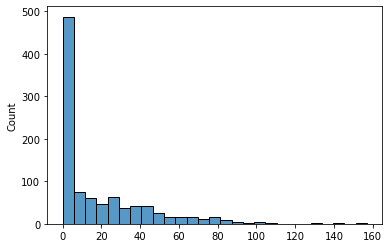

In [133]:
sns.histplot([v for k, v in nx.degree(GAAdj)])

Text(0.5, 1.0, 'Eigenvector')

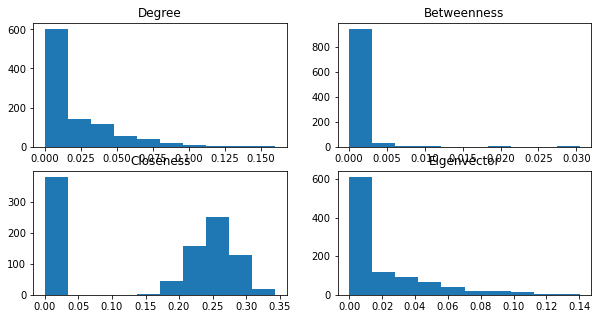

In [136]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5))

axs[0, 0].hist(nx.centrality.degree_centrality(GAAdj).values())
axs[0, 0].set_title('Degree')

axs[0, 1].hist(nx.centrality.betweenness_centrality(GAAdj).values())
axs[0, 1].set_title('Betweenness')

axs[1, 0].hist(nx.centrality.closeness_centrality(GAAdj).values())
axs[1, 0].set_title('Closeness')

axs[1, 1].hist(nx.centrality.eigenvector_centrality(GAAdj).values())
axs[1, 1].set_title('Eigenvector')

In [135]:
#Cluster Average
print("Clustering Average:", nx.cluster.average_clustering(GAAdj))

#Number of connected components
print("Number of connected components: ", nx.number_connected_components(GAAdj))

#Size of largest connected components
print("Size of largest connected components:", len(max(nx.connected_components(GAAdj), key = len)))

Clustering Average: 0.23096326846855988
Number of connected components:  381
Size of largest connected components: 603


## Number of ties between people of the same sex

In [117]:
number_ties = 0
no_gender_nodes = 0

for u,v in GAAdj.edges():
    #Note: There are some node without gender attribute, we ignore them in this scenari
    try: 
      if (GAAdj.nodes[u]['gender'] == GAAdj.nodes[v]['gender']):
        number_ties += 1
    except:
       no_gender_nodes += 1
       pass

print("Number of Ties between Same Sex: ", number_ties)
print("Number of Nodes without Gender Attribute: ", no_gender_nodes)

both_labeled_edges = 0
not_labeled_edges = 0 

for u,v in GAAdj.edges():
    #Note: There are some node without gender attribute, we ignore them in this scenari
    try: 
      if (GAAdj.nodes[u]['gender']) and (GAAdj.nodes[v]['gender']):
        both_labeled_edges += 1
    except:
       not_labeled_edges += 1
       pass
    
#print((both_labeled_edges + not_labeled_edges) == GAAdj.number_of_edges())
print("Percentage of Reaching out to Same Gender, excluding non-gendered nodes:", number_ties / both_labeled_edges)


Number of Ties between Same Sex:  3718
Number of Nodes without Gender Attribute:  2404
Percentage of Reaching out to Same Gender, excluding non-gendered nodes: 0.5631626779763708


In [ ]:
# Number of ties between people working in the same department

# Number of ties between different combinations of leaders(1) and non-leaders(0)
# Total messages sent: sum of (messages sent from sender to receiver)/100 for all Advice ties